# SETUP & CONFIGURATION

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Paths
sys.path.append('..')
base = Path('..')
DATA_DIR = base / 'data' / 'processed'
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Pandas display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.grid'] = False


print("✅ Libraries imported successfully!")
print(f"📁 Data directory: {DATA_DIR.resolve()}")

✅ Libraries imported successfully!
📁 Data directory: E:\code\DataPrepPrj\data\processed


# DATA LOADING

In [2]:
# Load dataset
clean_path = DATA_DIR / "clean_2015.csv"
df = pd.read_csv(clean_path)

print(f"\n📊 Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

print(f"\n📝 Sample columns: {list(df.columns[:10])}")

# Copy to working dataframe
df_fe = df.copy()
print("\n✅ Working dataframe `df_fe` created.")

# Missing values summary
missing = df_fe.isna().mean().sort_values(ascending=False)
print("\n🕳️ Missing value ratio (top 10):")
print(missing.head(10))


📊 Dataset loaded: 437,514 rows × 86 columns

📝 Sample columns: ['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'CHOLCHK']

✅ Working dataframe `df_fe` created.

🕳️ Missing value ratio (top 10):
PAMIN21_    0.362459
PAMIN11_    0.357385
PAVIG21_    0.356453
_MINAC21    0.355931
_MINAC11    0.350793
ACTIN21_    0.349333
PADUR1_     0.346757
PAVIG11_    0.346556
METVL21_    0.342542
EXRACT21    0.342542
dtype: float64


---
# 1. Demographic & Socioeconomic
---
Create demographic features that summarize key population characteristics (age, sex, race, employment) which influence baseline cardiovascular risk.

### 1.1 Age

Age is one of the strongest predictors of heart disease, so grouping and flagging age helps the model learn age-related risk patterns.

In [3]:
from src.feature_engineering import add_age_features

df_fe_add_age = add_age_features(df_fe)

print(f"Created columns: Age, AgeGroup, Age_65plus, AgeBucket")
print(f"Total columns: {df_fe_add_age.shape[1]}\n")

print(f"Missing _AGE80: {df_fe['_AGE80'].isna().sum():,} rows")
print(f"Missing Age: {df_fe_add_age['Age'].isna().sum():,} rows")
print(f"Missing AgeGroup: {df_fe_add_age['AgeGroup'].isna().sum():,} rows")
print(f"Missing Age_65plus: {df_fe_add_age['Age_65plus'].isna().sum():,} rows")
print(f"Missing AgeBucket: {df_fe_add_age['AgeBucket'].isna().sum():,} rows\n")

print("\nSample:")
print(df_fe_add_age[["Age", "AgeGroup", "Age_65plus", "AgeBucket"]].head())

print("\nAgeGroup distribution (top 3):")
print(df_fe_add_age["AgeGroup"].value_counts(dropna=False).head(3))

print("\nAgeBucket distribution:")
print(df_fe_add_age["AgeBucket"].value_counts(dropna=False))


AGE FEATURES
Created columns: Age, AgeGroup, Age_65plus, AgeBucket
Total columns: 90

Missing _AGE80: 0 rows
Missing Age: 0 rows
Missing AgeGroup: 0 rows
Missing Age_65plus: 0 rows
Missing AgeBucket: 0 rows


Sample:
   Age AgeGroup  Age_65plus AgeBucket
0   63    55-64         0.0    Middle
1   52    45-54         0.0    Middle
2   63    55-64         0.0    Middle
3   61    55-64         0.0    Middle
4   73      65+         1.0    Senior

AgeGroup distribution (top 3):
AgeGroup
65+      151028
55-64     97812
45-54     71471
Name: count, dtype: int64

AgeBucket distribution:
AgeBucket
Middle    169283
Senior    151028
Young     117203
Name: count, dtype: int64


### 1.2 Sex

Sex differences influence cardiovascular risk; using a single binary flag (IsMale) captures this signal cleanly without needing one-hot encoding.

In [5]:
from src.feature_engineering import add_sex_features

df_fe_add_sex = add_sex_features(df_fe_add_age)

print(f"Created columns: IsMale")
print(f"Total columns: {df_fe_add_sex.shape[1]}\n")

print(f"Missing SEX: {df_fe['SEX'].isna().sum():,} rows")
print(f"Missing IsMale: {df_fe_add_sex['IsMale'].isna().sum():,} rows\n")

print("IsMale distribution:")
print(df_fe_add_sex["IsMale"].value_counts(dropna=False))

print("\nSample:")
print(df_fe_add_sex[["SEX", "IsMale"]].head())


SEX FEATURES
Created columns: IsMale
Total columns: 91

Missing SEX: 0 rows
Missing IsMale: 0 rows

IsMale distribution:
IsMale
0.0    252330
1.0    185184
Name: count, dtype: int64

Sample:
   SEX  IsMale
0    2     0.0
1    2     0.0
2    2     0.0
3    2     0.0
4    2     0.0


### 1.3 Race

Race captures broad population health disparities; a few binary flags provide the essential signal without the overhead of full one-hot encoding.

In [7]:
from src.feature_engineering import add_race_features

df_fe_add_race = add_race_features(df_fe_add_sex)

print(f"Created columns: Race_White, Race_Black, Race_Hispanic")
print(f"Total columns: {df_fe_add_race.shape[1]}\n")

print(f"Missing _RACEGR3: {df_fe['_RACEGR3'].isna().sum():,} rows")
print(f"Missing Race_White: {df_fe_add_race['Race_White'].isna().sum():,} rows")
print(f"Missing Race_Black: {df_fe_add_race['Race_Black'].isna().sum():,} rows")
print(f"Missing Race_Hispanic: {df_fe_add_race['Race_Hispanic'].isna().sum():,} rows\n")

print("Race flags (sum of 1s):")
print(f"  White    = {int(df_fe_add_race['Race_White'].sum(skipna=True)):,}")
print(f"  Black    = {int(df_fe_add_race['Race_Black'].sum(skipna=True)):,}")
print(f"  Hispanic = {int(df_fe_add_race['Race_Hispanic'].sum(skipna=True)):,}")

print("\nSample:")
print(df_fe_add_race[["_RACEGR3", "Race_White", "Race_Black", "Race_Hispanic"]].head())


RACE FEATURES
Created columns: Race_White, Race_Black, Race_Hispanic
Total columns: 94

Missing _RACEGR3: 7,235 rows
Missing Race_White: 7,235 rows
Missing Race_Black: 7,235 rows
Missing Race_Hispanic: 7,235 rows

Race flags (sum of 1s):
  White    = 333,345
  Black    = 33,963
  Hispanic = 35,488

Sample:
   _RACEGR3  Race_White  Race_Black  Race_Hispanic
0       1.0         1.0         0.0            0.0
1       1.0         1.0         0.0            0.0
2       1.0         1.0         0.0            0.0
3       1.0         1.0         0.0            0.0
4       1.0         1.0         0.0            0.0


### 1.4 Employment

Employment status, especially “unable to work,” is a strong health indicator; a simple flag highlights this effect more directly than encoding all categories.

In [9]:
from src.feature_engineering import add_employ_features

df_fe_add_employ = add_employ_features(df_fe_add_race)

print(f"Added column: UnableToWork_flag")
print(f"Total columns: {df_fe_add_employ.shape[1]}\n")

print(f"Missing EMPLOY1: {df_fe['EMPLOY1'].isna().sum():,} rows")
print(f"Missing UnableToWork_flag: {df_fe_add_employ['UnableToWork_flag'].isna().sum():,} rows\n")

print("UnableToWork_flag distribution:")
print(df_fe_add_employ["UnableToWork_flag"].value_counts(dropna=False))

print("\nSample:")
print(df_fe_add_employ[["EMPLOY1", "UnableToWork_flag"]].head())


EMPLOYMENT FEATURES
Added column: UnableToWork_flag
Total columns: 95

Missing EMPLOY1: 3,685 rows
Missing UnableToWork_flag: 3,685 rows

UnableToWork_flag distribution:
UnableToWork_flag
0.0    402577
1.0     31252
NaN      3685
Name: count, dtype: int64

Sample:
   EMPLOY1  UnableToWork_flag
0      8.0                1.0
1      3.0                0.0
2      8.0                1.0
3      8.0                1.0
4      2.0                0.0


---
# 2. Anthropometric
---
Use BMI categories to derive simple weight-related risk flags, separating obesity from overweight, so the model can capture both high-risk (obese) and elevated-risk (overweight or obese) groups clearly.

In [10]:
from src.feature_engineering import add_bmi_features

df_fe_add_bmi = add_bmi_features(df_fe_add_employ)

print(f"Added column: Obese_flag, OverweightOrObese_flag, Underweight_flag")
print(f"Total columns: {df_fe_add_bmi.shape[1]}\n")

print(f"Obese_flag distribution:")
print(df_fe_add_bmi["Obese_flag"].value_counts(dropna=False))

print("\nOverweightOrObese_flag distribution:")
print(df_fe_add_bmi["OverweightOrObese_flag"].value_counts(dropna=False))

print("\nUnderweight_flag distribution:")
print(df_fe_add_bmi["Underweight_flag"].value_counts(dropna=False))

print("\nSample:")
cols_preview = []
for c in ["_BMI5CAT", "_RFBMI5", "Obese_flag", "OverweightOrObese_flag", "Underweight_flag"]:
    if c in df_fe_add_bmi.columns:
        cols_preview.append(c)
print(df_fe_add_bmi[cols_preview].head())


BMI FEATURES
Added column: Obese_flag, OverweightOrObese_flag, Underweight_flag
Total columns: 98

Obese_flag distribution:
Obese_flag
0.0    282885
1.0    118700
NaN     35929
Name: count, dtype: int64

OverweightOrObese_flag distribution:
OverweightOrObese_flag
1.0    264471
0.0    137114
NaN     35929
Name: count, dtype: int64

Underweight_flag distribution:
Underweight_flag
0.0    394949
NaN     35929
1.0      6636
Name: count, dtype: int64

Sample:
   _BMI5CAT  _RFBMI5  Obese_flag  OverweightOrObese_flag  Underweight_flag
0       4.0      1.0         1.0                     1.0               0.0
1       3.0      1.0         0.0                     1.0               0.0
2       3.0      1.0         0.0                     1.0               0.0
3       2.0      0.0         0.0                     0.0               0.0
4       3.0      1.0         0.0                     1.0               0.0


---
# 3. Clinical Conditions
---
Create disease-based flags (hypertension, diabetes, cholesterol, prior CVD, etc.) that represent core medical risk factors directly linked to cardiovascular outcomes.

### 3.1 Hypertension

High blood pressure is a core cardiometabolic risk factor; using BRFSS risk flags and diagnosis history to build a clean binary indicator improves model signal consistency.

In [12]:
from src.feature_engineering import add_hypertension_features

df_fe_hypertension = add_hypertension_features(df_fe_add_bmi)

print(f"Added column: Hypertension_flag")
print(f"Total columns: {df_fe_hypertension.shape[1]}\n")

print(f"Missing _RFHYPE5: {df_fe['_RFHYPE5'].isna().sum()} rows")
print(f"Missing BPHIGH4: {df_fe['BPHIGH4'].isna().sum()} rows")
print(f"Missing nHypertension_flag: {df_fe_hypertension['Hypertension_flag'].isna().sum()} rows")

print("\nHypertension_flag distribution:")
print(df_fe_hypertension["Hypertension_flag"].value_counts(dropna=False))

cols_show = [c for c in ["_RFHYPE5", "BPHIGH4", "Hypertension_flag"] if c in df_fe_hypertension.columns]
print("\nSample:")
print(df_fe_hypertension[cols_show].head())


HYPERTENSION FEATURES
Added column: Hypertension_flag
Total columns: 99

Missing _RFHYPE5: 1232 rows
Missing BPHIGH4: 1232 rows
Missing nHypertension_flag: 1232 rows

Hypertension_flag distribution:
Hypertension_flag
0.0    260540
1.0    175742
NaN      1232
Name: count, dtype: int64

Sample:
   _RFHYPE5  BPHIGH4  Hypertension_flag
0       1.0      1.0                1.0
1       0.0      3.0                0.0
2       1.0      1.0                1.0
3       0.0      3.0                0.0
4       1.0      1.0                1.0


### 3.2 High Cholesterol

In [14]:
from src.feature_engineering import add_highchol_features

df_fe_highchol = add_highchol_features(df_fe_hypertension)

print(f"Added column: HighChol")
print(f"Total columns: {df_fe_highchol.shape[1]}\n")
print(f"Missing _RFCHOL: {df_fe['_RFCHOL'].isna().sum()} rows")
print(f"Missing HighChol_flag: {df_fe_highchol['HighChol_flag'].isna().sum()} rows\n")

print("HighChol distribution:")
print(df_fe_highchol["HighChol_flag"].value_counts(dropna=False))


HIGH CHOLESTEROL FEATURES
Added column: HighChol
Total columns: 100

Missing _RFCHOL: 61973 rows
Missing HighChol_flag: 61973 rows

HighChol distribution:
HighChol_flag
0.0    217488
1.0    158053
NaN     61973
Name: count, dtype: int64


### 3.3 Diabetes

In [16]:
from src.feature_engineering import add_diabetes_features

df_fe_diabetes = add_diabetes_features(df_fe_highchol)

print(f"Added column: Diabetes, PreDiabetes")
print(f"Total columns: {df_fe_diabetes.shape[1]}\n")

print(f"Missing DIABETE3: {df_fe['DIABETE3'].isna().sum()} rows")
print(f"Missing Diabetes: {df_fe_diabetes['Diabetes'].isna().sum()} rows")
print(f"Missing PreDiabetes: {df_fe_diabetes['PreDiabetes'].isna().sum()} rows\n")

print("Diabetes distribution:")
print(df_fe_diabetes["Diabetes"].value_counts(dropna=False))

print("\nPreDiabetes distribution:")
print(df_fe_diabetes["PreDiabetes"].value_counts(dropna=False))

print("\nSample:")
print(df_fe_diabetes[["DIABETE3", "Diabetes", "PreDiabetes"]].head())


DIABETES FEATURES
Added column: Diabetes, PreDiabetes
Total columns: 102

Missing DIABETE3: 633 rows
Missing Diabetes: 633 rows
Missing PreDiabetes: 633 rows

Diabetes distribution:
Diabetes
0.0    380503
1.0     56378
NaN       633
Name: count, dtype: int64

PreDiabetes distribution:
PreDiabetes
0.0    429327
1.0      7554
NaN       633
Name: count, dtype: int64

Sample:
   DIABETE3  Diabetes  PreDiabetes
0       3.0       0.0          0.0
1       3.0       0.0          0.0
2       3.0       0.0          0.0
3       3.0       0.0          0.0
4       3.0       0.0          0.0


### 3.4 CVD History

Construct flags for prior heart attack, coronary heart disease, and stroke to capture established CVD burden, using strict logic that preserves diagnostic certainty and missingness.

In [18]:
from src.feature_engineering import add_cvd_history_features

df_fe_cvd_hist = add_cvd_history_features(df_fe_diabetes)

print(f"Added column: HadMI, HadCHD, HadStroke, AnyCVD_flag")
print(f"Total columns: {df_fe_cvd_hist.shape[1]}\n")

print(f"Missing CVDINFR4 (MI): {df_fe['CVDINFR4'].isna().sum()} rows")
print(f"Missing CVDCRHD4 (angina/CHD): {df_fe['CVDCRHD4'].isna().sum()} rows")
print(f"Missing CVDSTRK3 (stroke): {df_fe['CVDSTRK3'].isna().sum()} rows\n")

print(f"Missing HadMI: {df_fe_cvd_hist['HadMI'].isna().sum()} rows")
print(f"Missing HadCHD: {df_fe_cvd_hist['HadCHD'].isna().sum()} rows")
print(f"Missing HadStroke: {df_fe_cvd_hist['HadStroke'].isna().sum()} rows")
print(f"Missing AnyCVD_flag: {df_fe_cvd_hist['AnyCVD_flag'].isna().sum()} rows\n")

print("\nDistribution:")
for col in ["HadMI", "HadCHD", "HadStroke", "AnyCVD_flag"]:
    if col in df_fe_cvd_hist.columns:
        print(f"{col}:")
        print(df_fe_cvd_hist[col].value_counts(dropna=False))
        print()

print("Sample:")
show_cols = [c for c in ["CVDINFR4", "CVDCRHD4", "CVDSTRK3",
                        "HadMI", "HadCHD", "HadStroke", "AnyCVD_flag"]
            if c in df_fe_cvd_hist.columns]
print(df_fe_cvd_hist[show_cols].head())


CARDIOVASCULAR HISTORY FEATURES
Added column: HadMI, HadCHD, HadStroke, AnyCVD_flag
Total columns: 106

Missing CVDINFR4 (MI): 361 rows
Missing CVDCRHD4 (angina/CHD): 1278 rows
Missing CVDSTRK3 (stroke): 989 rows

Missing HadMI: 361 rows
Missing HadCHD: 1278 rows
Missing HadStroke: 989 rows
Missing AnyCVD_flag: 670 rows


Distribution:
HadMI:
HadMI
0.0    411681
1.0     25472
NaN       361
Name: count, dtype: int64

HadCHD:
HadCHD
0.0    410946
1.0     25290
NaN      1278
Name: count, dtype: int64

HadStroke:
HadStroke
0.0    418713
1.0     17812
NaN       989
Name: count, dtype: int64

AnyCVD_flag:
AnyCVD_flag
0.0    387071
1.0     49773
NaN       670
Name: count, dtype: int64

Sample:
   CVDINFR4  CVDCRHD4  CVDSTRK3  HadMI  HadCHD  HadStroke  AnyCVD_flag
0       0.0       0.0       0.0    0.0     0.0        0.0          0.0
1       0.0       0.0       0.0    0.0     0.0        0.0          0.0
2       0.0       0.0       0.0    0.0     0.0        0.0          0.0
3       0.0       0

### 3.5 Pulmonary & respiratory

In [20]:
from src.feature_engineering import add_respiratory_features

df_fe_resp = add_respiratory_features(df_fe_cvd_hist)

print(f"Added column: COPD_flag, CurrentAsthma_flag, EverAsthma_flag, Asthma_Remission_flag")
print(f"Total columns: {df_fe_resp.shape[1]}\n")

print(f"Missing CHCCOPD1: {df_fe['CHCCOPD1'].isna().sum()} rows")
print(f"Missing _ASTHMS1: {df_fe['_ASTHMS1'].isna().sum()} rows")

print("\nDistribution:")
for col in ["COPD_flag", "CurrentAsthma_flag", "EverAsthma_flag", "Asthma_Remission_flag"]:
    if col in df_fe_resp.columns:
        print(df_fe_resp[col].value_counts(dropna=False))
        print()

print("Sample:")
show_cols = [c for c in ["CHCCOPD1", "_ASTHMS1",
                        "COPD_flag", "CurrentAsthma_flag",
                        "EverAsthma_flag", "Asthma_Remission_flag"]
            if c in df_fe_resp.columns]
print(df_fe_resp[show_cols].head())


RESPIRATORY FEATURES
Added column: COPD_flag, CurrentAsthma_flag, EverAsthma_flag, Asthma_Remission_flag
Total columns: 110

Missing CHCCOPD1: 2046 rows
Missing _ASTHMS1: 3044 rows

Distribution:
COPD_flag
0.0    400692
1.0     34776
NaN      2046
Name: count, dtype: int64

CurrentAsthma_flag
0.0    395005
1.0     39465
NaN      3044
Name: count, dtype: int64

EverAsthma_flag
0.0    377572
1.0     56898
NaN      3044
Name: count, dtype: int64

Asthma_Remission_flag
0.0    417037
1.0     17433
NaN      3044
Name: count, dtype: int64

Sample:
   CHCCOPD1  _ASTHMS1  COPD_flag  CurrentAsthma_flag  EverAsthma_flag  Asthma_Remission_flag
0       1.0       1.0        1.0                 1.0              1.0                    0.0
1       0.0       3.0        0.0                 0.0              0.0                    0.0
2       0.0       3.0        0.0                 0.0              0.0                    0.0
3       0.0       3.0        0.0                 0.0              0.0           

---
# 4. Health Status & Quality of Life
---

### 4.1 Self-rated health

In [22]:
from src.feature_engineering import add_selfrated_health_features

df_fe_selfrated = add_selfrated_health_features(df_fe_resp)

print(f"Added column: PoorHealth_flag, VeryPoorHealth_flag")
print(f"Total columns: {df_fe_selfrated.shape[1]}\n")

print(f"Missing GENHLTH: {df_fe['GENHLTH'].isna().sum()} rows\n")

print("PoorHealth_flag distribution:")
print(df_fe_selfrated["PoorHealth_flag"].value_counts(dropna=False))

print("\nVeryPoorHealth_flag distribution:")
print(df_fe_selfrated["VeryPoorHealth_flag"].value_counts(dropna=False))


SELF-RATED HEALTH FEATURES
Added column: PoorHealth_flag, VeryPoorHealth_flag
Total columns: 112

Missing GENHLTH: 1190 rows

PoorHealth_flag distribution:
PoorHealth_flag
0.0    355863
1.0     80461
NaN      1190
Name: count, dtype: int64

VeryPoorHealth_flag distribution:
VeryPoorHealth_flag
0.0    413759
1.0     22565
NaN      1190
Name: count, dtype: int64


### 4.2 Poor health day

In [24]:
from src.feature_engineering import add_poor_health_day_features

df_fe_poor_health_day = add_poor_health_day_features(df_fe_selfrated)

print(f"Added column: PoorPhysical14plus_flag, PoorMental14plus_flag, AnyActivityLimitation_flag")
print(f"Total columns: {df_fe_poor_health_day.shape[1]}\n")

print(f"Missing PHYSHLTH: {df_fe['PHYSHLTH'].isna().sum()} rows")
print(f"Missing MENTHLTH: {df_fe['MENTHLTH'].isna().sum()} rows")
print(f"Missing POORHLTH: {df_fe['POORHLTH'].isna().sum()} rows\n")

print("\nDistribution:")
for col in ["PoorPhysical14plus_flag", "PoorMental14plus_flag", "AnyActivityLimitation_flag"]:
    if col in df_fe_poor_health_day.columns:
        print(df_fe_poor_health_day[col].value_counts(dropna=False))
        print()



POOR HEALTH DAYS FEATURES
Added column: PoorPhysical14plus_flag, PoorMental14plus_flag, AnyActivityLimitation_flag
Total columns: 115

Missing PHYSHLTH: 9419 rows
Missing MENTHLTH: 7146 rows
Missing POORHLTH: 4789 rows


Distribution:
PoorPhysical14plus_flag
0.0    370810
1.0     57285
NaN      9419
Name: count, dtype: int64

PoorMental14plus_flag
0.0    386534
1.0     43834
NaN      7146
Name: count, dtype: int64

AnyActivityLimitation_flag
0.0    337940
1.0     94785
NaN      4789
Name: count, dtype: int64



---
# 5. Lifestyle & Access
---

### 5.1 Smoking

In [26]:
from src.feature_engineering import add_smoking_features

df_fe_smoking = add_smoking_features(df_fe_poor_health_day)

print(f"Added column: CurrentSmoker, FormerSmoker, NeverSmoker")
print(f"Total columns: {df_fe_smoking.shape[1]}\n")

print(f"Missing _SMOKER3: {df_fe['_SMOKER3'].isna().sum()} rows\n")

print("Distributions:")
print(df_fe_smoking["CurrentSmoker"].value_counts(dropna=False))
print(df_fe_smoking["FormerSmoker"].value_counts(dropna=False))
print(df_fe_smoking["NeverSmoker"].value_counts(dropna=False))



SMOKING FEATURES
Added column: CurrentSmoker, FormerSmoker, NeverSmoker
Total columns: 118

Missing _SMOKER3: 17685 rows

Distributions:
CurrentSmoker
0.0    358859
1.0     60970
NaN     17685
Name: count, dtype: int64
FormerSmoker
0.0    298783
1.0    121046
NaN     17685
Name: count, dtype: int64
NeverSmoker
1.0    237813
0.0    182016
NaN     17685
Name: count, dtype: int64


### 5.2 Physical Activity

In [28]:
from src.feature_engineering import add_physical_activity_features

df_fe_physic_act = add_physical_activity_features(df_fe_smoking)

print(f"Added column: AnyAerobicActivity_flag, AnyStrengthActivity_flag, AnyExercise_flag")
print(f"Total columns: {df_fe_physic_act.shape[1]}\n")

print(f"Missing EXRACT11: {df_fe['EXRACT11'].isna().sum()} rows")
print(f"Missing EXRACT21: {df_fe['EXRACT21'].isna().sum()} rows\n")

print("Distributions:")
print(df_fe_physic_act["AnyAerobicActivity_flag"].value_counts(dropna=False), "\n")
print(df_fe_physic_act["AnyStrengthActivity_flag"].value_counts(dropna=False), "\n")
print(df_fe_physic_act["AnyExercise_flag"].value_counts(dropna=False))

preview_cols = [
        "EXRACT11", "EXRACT21",
        "AnyAerobicActivity_flag", 
        "AnyStrengthActivity_flag", 
        "AnyExercise_flag"
    ]
existing = [c for c in preview_cols if c in df_fe_physic_act.columns]

print("\nSample rows:")
print(df_fe_physic_act[existing].head())


PHYSICAL ACTIVITY FEATURES
Added column: AnyAerobicActivity_flag, AnyStrengthActivity_flag, AnyExercise_flag
Total columns: 121

Missing EXRACT11: 144985 rows
Missing EXRACT21: 149867 rows

Distributions:
AnyAerobicActivity_flag
1.0    292529
NaN    144985
Name: count, dtype: int64 

AnyStrengthActivity_flag
1.0    196065
NaN    149867
0.0     91582
Name: count, dtype: int64 

AnyExercise_flag
1.0    292529
NaN    144985
Name: count, dtype: int64

Sample rows:
   EXRACT11  EXRACT21  AnyAerobicActivity_flag  AnyStrengthActivity_flag  AnyExercise_flag
0       NaN       NaN                      NaN                       NaN               NaN
1      64.0      69.0                      1.0                       1.0               1.0
2       NaN       NaN                      NaN                       NaN               NaN
3       NaN       NaN                      NaN                       NaN               NaN
4      18.0      73.0                      1.0                       1.0       

### 5.3 Access to care

In [29]:
from src.feature_engineering import add_access_features

df_fe_access = add_access_features(df_fe_physic_act)

print(f"Added column: HasInsurance_flag, HasPrimaryDoctor_flag, CouldNotAffordCare_flag, RecentCheckup_flag")
print(f"Total columns: {df_fe_access.shape[1]}\n")

print("Distributions:")
for col in [
        "HasInsurance_flag",
        "HasPrimaryDoctor_flag",
        "CouldNotAffordCare_flag",
        "RecentCheckup_flag",
    ]:
        if col in df_fe_access.columns:
            print(df_fe_access[col].value_counts(dropna=False), "\n")



ACCESS TO CARE FEATURES
Added column: HasInsurance_flag, HasPrimaryDoctor_flag, CouldNotAffordCare_flag, RecentCheckup_flag
Total columns: 125

Distributions:
HasInsurance_flag
1.0    403996
0.0     31752
NaN      1766
Name: count, dtype: int64 

HasPrimaryDoctor_flag
1.0    372473
0.0     63251
NaN      1790
Name: count, dtype: int64 

CouldNotAffordCare_flag
0.0    393530
1.0     42866
NaN      1118
Name: count, dtype: int64 

RecentCheckup_flag
1.0    322442
0.0    105347
NaN      9725
Name: count, dtype: int64 



---
# 6. Interaction & Composite
---

Create clinically meaningful composite features and interaction terms based on EDA findings. Use strict rules for binary interactions and add missing flags to avoid misleading zeros.

### 6.1 Risk Factor Cluster

Count how many major CVD risk factors (hypertension, high cholesterol, diabetes, obesity, smoking) are present for each person. The RiskFactorCount feature captures the nonlinear increase in CVD risk as multiple risk factors accumulate.


In [30]:
from src.feature_engineering import add_riskfactor_features

df_fe_risk = add_riskfactor_features(df_fe_access)



INTERACTION – RISK FACTOR CLUSTER
Using risk factor columns: ['Hypertension_flag', 'HighChol_flag', 'Diabetes', 'Obese_flag', 'CurrentSmoker']

RiskFactorCount distribution:
RiskFactorCount
0.0    134620
1.0    131537
2.0     98534
3.0     51905
4.0     19057
5.0      1859
NaN         2
Name: count, dtype: int64

RiskFactor_missing_any distribution:
RiskFactor_missing_any
0.0    337536
1.0     99978
Name: count, dtype: int64

Sample (RF cols + RiskFactorCount):
   Hypertension_flag  HighChol_flag  Diabetes  Obese_flag  CurrentSmoker  RiskFactorCount  RiskFactor_missing_any
0                1.0            1.0       0.0         1.0            0.0              3.0                     0.0
1                0.0            0.0       0.0         0.0            1.0              1.0                     0.0
2                1.0            1.0       0.0         0.0            0.0              2.0                     0.0
3                0.0            0.0       0.0         0.0            0.0     

### 6.2 Metabolic Syndrome

Combine obesity, hypertension, high cholesterol, and diabetes into a single MetabolicSyndrome_flag that is 1 when at least three components are present. This feature captures the well-known clustering of metabolic risk factors that dramatically increases CVD risk.


In [31]:
from src.feature_engineering import add_metabolic_syndrome_features

df_fe_metabolic = add_metabolic_syndrome_features(df_fe_risk)


INTERACTION – METABOLIC SYNDROME
Using metabolic components: ['Diabetes', 'Hypertension_flag', 'Obese_flag']

MetabolicSyndrome_flag distribution:
MetabolicSyndrome_flag
0.0    415667
1.0     21825
NaN        22
Name: count, dtype: int64

MetSyn_missing_flag distribution:
MetSyn_missing_flag
0.0    400139
1.0     37375
Name: count, dtype: int64

Sample (metabolic + MetabolicSyndrome_flag):
   Diabetes  Hypertension_flag  Obese_flag  MetabolicSyndrome_flag  MetSyn_missing_flag
0       0.0                1.0         1.0                     0.0                  0.0
1       0.0                0.0         0.0                     0.0                  0.0
2       0.0                1.0         0.0                     0.0                  0.0
3       0.0                0.0         0.0                     0.0                  0.0
4       0.0                1.0         0.0                     0.0                  0.0


### 6.3 Binary Interaction Combos

Create strict binary interactions such as Obese_and_Hypertensive or HTN_and_Diabetes, set to 1 only when all components are 1. These flags highlight clinically dangerous combinations of risk factors rather than treating each condition in isolation.

In [32]:
from src.feature_engineering import add_binary_interactions

df_fe_bin_int = add_binary_interactions(df_fe_metabolic)


INTERACTION – BINARY COMBOS

Creating interaction: Obese_and_Inactive_flag from ['Obese_flag', 'Inactive_flag']
Obese_and_Inactive_flag distribution:
Obese_and_Inactive_flag
0.0    275554
NaN    161960
Name: count, dtype: int64

Creating interaction: Obese_and_Hypertensive_flag from ['Obese_flag', 'Hypertension_flag']
Obese_and_Hypertensive_flag distribution:
Obese_and_Hypertensive_flag
0.0    335389
1.0     65249
NaN     36876
Name: count, dtype: int64

Creating interaction: HTN_and_Diabetes_flag from ['Hypertension_flag', 'Diabetes']
HTN_and_Diabetes_flag distribution:
HTN_and_Diabetes_flag
0.0    393514
1.0     42174
NaN      1826
Name: count, dtype: int64

Creating interaction: Diabetes_and_HighChol_flag from ['Diabetes', 'HighChol_flag']
Diabetes_and_HighChol_flag distribution:
Diabetes_and_HighChol_flag
0.0    339486
NaN     62422
1.0     35606
Name: count, dtype: int64
HTN_and_Diabetes_flag distribution:
HTN_and_Diabetes_flag
0.0    393514
1.0     42174
NaN      1826
Name: coun

### 6.4 Numeric × Binary Interactions

Use Age × CurrentSmoker to model how the impact of smoking varies by age. This captures effect modification where smoking at younger ages may carry a different CVD risk profile than smoking at older ages.


In [33]:
from src.feature_engineering import add_numeric_interactions

df_fe_num_int = add_numeric_interactions(df_fe_bin_int)


INTERACTION – NUMERIC × BINARY

Age_x_CurrentSmoker summary:
count    419829.000000
mean          7.346298
std          18.768125
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          80.000000
Name: Age_x_CurrentSmoker, dtype: float64


## DROP REDUNDANT RAW COLUMNS

In [34]:
# update df_fe
df_fe = df_fe_num_int

raw_cols_to_drop = ["_AGE80", "_RACEGR3", "SEX", "_RFBMI5", 
                    "_RFHYPE5", "BPHIGH4", "_RFCHOL", "TOLDHI2",
                    "DIABETE3", "CVDINFR4", "CVDCRHD4", "CVDSTRK3",
                    "ASTHMA3", "_ASTHMS1", "CHCCOPD1", "_SMOKER3",
                    "_RFSMOK3", "EXRACT11", "EXRACT21", "HLTHPLN1",
                    "PERSDOC2","MEDCOST",
]
df_fe = df_fe.drop(columns=raw_cols_to_drop)

---
# 7. Data Quality 
---


### 7.1 Data Quality Check

In [35]:
print("\n" + "="*80)
print(" DATA QUALITY CHECK")
print("="*80)

print(f"\nShape: {df_fe.shape}")
# Check for missing values
print("\n🔍 Missing Values (top 20):")
missing = df_fe.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) == 0:
    print("   ✅ No missing values!")
else:
    print(missing.head(20).apply(lambda x: f"{x:,} ({x/len(df_fe)*100:.2f}%)"))

# Check for infinite values
print("\n🔍 Infinite Values:")
num_cols = df_fe.select_dtypes(include=[np.number])
inf_mask = np.isinf(num_cols)
inf_total = inf_mask.sum().sum()

if inf_total == 0:
    print("   ✅ No infinite values!")
else:
    print(f"   ⚠️ Found {inf_total} infinite values in columns:")
    bad_cols = num_cols.columns[inf_mask.any(axis=0)]
    for c in bad_cols:
        print(f"      - {c}")

# Check for duplicates
print(f"\n🔍 Duplicate Rows:")
dup_count = df_fe.duplicated().sum()
print(f"   Duplicates: {dup_count}")

# Data Types Summary
# ------------------------------
print("\n🔍 Data Types Summary:")
n_num = df_fe.select_dtypes(include=[np.number]).shape[1]
n_cat = df_fe.select_dtypes(include=['object', 'category']).shape[1]
n_other = df_fe.shape[1] - n_num - n_cat

print(f"   Numeric columns    : {n_num}")
print(f"   Categorical columns: {n_cat}")
print(f"   Other types        : {n_other}")


 DATA QUALITY CHECK

Shape: (437514, 117)

🔍 Missing Values (top 20):
Obese_and_Inactive_flag     161,960 (37.02%)
PAMIN21_                    158,581 (36.25%)
PAMIN11_                    156,361 (35.74%)
PAVIG21_                    155,953 (35.65%)
_MINAC21                    155,725 (35.59%)
_MINAC11                    153,477 (35.08%)
ACTIN21_                    152,838 (34.93%)
PADUR1_                     151,711 (34.68%)
PAVIG11_                    151,623 (34.66%)
AnyStrengthActivity_flag    149,867 (34.25%)
METVL21_                    149,867 (34.25%)
PAFREQ1_                    148,341 (33.91%)
ACTIN11_                    148,055 (33.84%)
METVL11_                    144,985 (33.14%)
AnyExercise_flag            144,985 (33.14%)
Inactive_flag               144,985 (33.14%)
AnyAerobicActivity_flag     144,985 (33.14%)
_INCOMG                      78,216 (17.88%)
INCOME2                      78,216 (17.88%)
PNEUVAC3                     77,275 (17.66%)
dtype: object

🔍 Infinite Val

### 7.2 Feature Statistics & Distribution

In [36]:
print("\n" + "="*70)
print("7.2 FEATURE STATISTICS & DISTRIBUTION CHECK")
print("="*70)

num_cols = df_fe.select_dtypes(include=[np.number]).columns
cat_cols = df_fe.select_dtypes(include=['object','category']).columns

# ---- basic stats (only numeric) ----
print(f"\n📊 Numeric Summary ({len(num_cols)} cols):")
display(df_fe[num_cols].describe().T[['mean','std','min','max']].round(3).head(20))

# ---- zero variance ----
var0 = df_fe[num_cols].var()
var0 = var0[var0 == 0]
print(f"\n🔍 Zero-variance features ({len(var0)}):")
if len(var0):
    for c in var0.index:
        print(f"   - {c}")
else:
    print("   ✓ None")

# ---- categorical summary ----
print(f"\n📊 Categorical Summary ({len(cat_cols)} cols):")
for c in cat_cols:
    print(f"   {c}: {df_fe[c].nunique()} unique")


7.2 FEATURE STATISTICS & DISTRIBUTION CHECK

📊 Numeric Summary (115 cols):

📊 Numeric Summary (115 cols):


,mean,std,min,max
GENHLTH,2.558,1.082,1.0,5.0
PHYSHLTH,4.262,8.778,0.0,30.0
MENTHLTH,3.298,7.591,0.0,30.0
POORHLTH,2.651,7.150,0.0,30.0
CHECKUP1,1.438,0.869,1.0,4.0
CHOLCHK,1.363,0.765,1.0,4.0
CHCSCNCR,0.094,0.292,0.0,1.0
CHCOCNCR,0.098,0.298,0.0,1.0
HAVARTH3,0.336,0.472,0.0,1.0
ADDEPEV2,0.190,0.392,0.0,1.0



🔍 Zero-variance features (4):
   - AnyAerobicActivity_flag
   - AnyExercise_flag
   - Inactive_flag
   - Obese_and_Inactive_flag

📊 Categorical Summary (2 cols):
   AgeGroup: 6 unique
   AgeBucket: 3 unique


### 7.3 Correlation with Target

In [37]:
print("\n" + "="*70)
print("7.3 FEATURE CORRELATION WITH TARGET")
print("="*70)

target = '_MICHD'
if target in df_fe.columns:
    num_cols = df_fe.select_dtypes(include=[np.number]).columns
    num_cols = [c for c in num_cols if c != target]

    corr = df_fe[num_cols + [target]].corr()[target].drop(target).abs()
    corr_sorted = corr.sort_values(ascending=False)

    print("\n🎯 Top 15 correlated features:")
    display(corr_sorted.head(15))

    print(f"""
📊 Summary:
  Strong  (>0.3): {(corr>0.3).sum()}
  Moderate(0.1–0.3): {((corr>=0.1)&(corr<=0.3)).sum()}
  Weak    (<0.1): {(corr<0.1).sum()}
""")
else:
    print("⚠️ Target _MICHD not found.")


7.3 FEATURE CORRELATION WITH TARGET

🎯 Top 15 correlated features:

🎯 Top 15 correlated features:


AnyCVD_flag            0.868602
HadCHD                 0.810642
HadMI                  0.803031
GENHLTH                0.249816
RiskFactorCount        0.247846
PoorHealth_flag        0.235181
Age                    0.225152
FC60_                  0.224514
MAXVO2_                0.224503
Hypertension_flag      0.218255
EMPLOY1                0.212411
HadStroke              0.209057
Age_65plus             0.203208
USEEQUIP               0.192975
VeryPoorHealth_flag    0.191784
Name: _MICHD, dtype: float64


📊 Summary:
  Strong  (>0.3): 3
  Moderate(0.1–0.3): 39
  Weak    (<0.1): 68



In [38]:
df_fe.columns.tolist()

['GENHLTH',
 'PHYSHLTH',
 'MENTHLTH',
 'POORHLTH',
 'CHECKUP1',
 'CHOLCHK',
 'CHCSCNCR',
 'CHCOCNCR',
 'HAVARTH3',
 'ADDEPEV2',
 'CHCKIDNY',
 'MARITAL',
 'EDUCA',
 'EMPLOY1',
 'CHILDREN',
 'INCOME2',
 'QLACTLM2',
 'USEEQUIP',
 'FLUSHOT6',
 'PNEUVAC3',
 '_CHOLCHK',
 '_MICHD',
 '_BMI5CAT',
 '_CHLDCNT',
 '_EDUCAG',
 '_INCOMG',
 'DRNKANY5',
 '_RFBING5',
 '_RFDRHV5',
 '_FRUTSUM',
 '_VEGESUM',
 '_FRTLT1',
 '_VEGLT1',
 '_TOTINDA',
 'METVL11_',
 'METVL21_',
 'MAXVO2_',
 'FC60_',
 'ACTIN11_',
 'ACTIN21_',
 'PADUR1_',
 'PAFREQ1_',
 '_MINAC11',
 '_MINAC21',
 'STRFREQ_',
 'PAMISS1_',
 'PAMIN11_',
 'PAMIN21_',
 'PAVIG11_',
 'PAVIG21_',
 '_PACAT1',
 '_PAINDX1',
 '_PA150R2',
 '_PA300R2',
 '_PA30021',
 '_PASTRNG',
 '_PAREC1',
 '_PASTAE1',
 '_LMTACT1',
 '_LMTWRK1',
 '_LMTSCL1',
 '_RFSEAT2',
 '_RFSEAT3',
 'PHYSICAL_DIFFICULTY',
 'Age',
 'AgeGroup',
 'Age_65plus',
 'AgeBucket',
 'IsMale',
 'Race_White',
 'Race_Black',
 'Race_Hispanic',
 'UnableToWork_flag',
 'Obese_flag',
 'OverweightOrObese_flag',
 'Und

---
# 8. Handle missing and outlier
---

## Missing and outlier overview

In [39]:
import pandas as pd
import numpy as np

def print_data_quality_report(df: pd.DataFrame):
    """
    In ra một bảng siêu đẹp: Missing % + Min + Max + Mean
    Dùng cho final check trước khi train model.
    """
    df = df.copy()
    
    print("\n" + "═" * 100)
    print(" " * 38 + "INITIAL DATA QUALITY REPORT")
    print("═" * 100)

    print(f"\nShape : {df.shape[0]:,} rows × {df.shape[1]:,} columns\n")

    # Tính thống kê cho tất cả cột numeric
    numeric_cols = df.select_dtypes(include=np.number).columns
    stats = []

    for col in numeric_cols:
        series = df[col]
        missing_count = series.isna().sum()
        missing_pct = missing_count / len(df) * 100
        
        stats.append({
            'Column': col,
            'Missing': missing_count,
            'Missing %': missing_pct,
            'Min': series.min(),
            'Max': series.max(),
            'Mean': series.mean()
        })

    # Tạo DataFrame và sort theo Missing % giảm dần
    stats_df = pd.DataFrame(stats)
    stats_df = stats_df.sort_values("Missing %", ascending=False).reset_index(drop=True)

    # Format đẹp
    pd.set_option('display.max_rows', None)
    pd.set_option('display.float_format', '{:,.2f}'.format)

    # Đổi tên cột cho đẹp
    display_df = stats_df.copy()
    display_df['Missing'] = display_df['Missing'].apply(lambda x: f"{x:,}")
    display_df['Missing %'] = display_df['Missing %'].apply(lambda x: f"{x:6.2f}%")
    display_df = display_df[['Column', 'Missing', 'Missing %', 'Min', 'Max', 'Mean']]

    display_df.columns = ['Column', 'Missing', 'Missing %', '    Min', '    Max', '   Mean']

    print(display_df.to_string(index=False))
    
    # Summary footer
    total_missing = stats_df['Missing'].sum()
    print(f"\nTotal missing values across all numeric columns : {total_missing:,}")
    print(f"Average missing rate                            : {stats_df['Missing %'].mean():.2f}%")


print_data_quality_report(df_fe)


════════════════════════════════════════════════════════════════════════════════════════════════════
                                      INITIAL DATA QUALITY REPORT
════════════════════════════════════════════════════════════════════════════════════════════════════

Shape : 437,514 rows × 117 columns

                                  Column Missing Missing %      Min       Max     Mean
                 Obese_and_Inactive_flag 161,960    37.02%     0.00      0.00     0.00
                                PAMIN21_ 158,581    36.25%     0.00 47,520.00   181.72
                                PAMIN11_ 156,361    35.74%     0.00 53,460.00   313.70
                                PAVIG21_ 155,953    35.65%     0.00 19,200.00    50.92
                                _MINAC21 155,725    35.59%     0.00 47,520.00   130.12
                                _MINAC11 153,477    35.08%     0.00 53,460.00   229.92
                                ACTIN21_ 152,838    34.93%     0.00      2.00     0.8

## 8.1. Missing Value Handling Strategy 



We applied a **5-tier, mechanism-aware imputation strategy** tailored to BRFSS survey structure and clinical interpretability:

| Tier | Missingness Level | Examples | Strategy | Rationale |
|------|-------------------|--------|---------|---------|
| 1 | Medium (9–18%) | `INCOME2`, `CHOLCHK`, `FLUSHOT6` | **Flag only** + optional `-1` imputation | Refusal/sensitivity → predictive signal preserved |
| 2 | Low–Medium (9–11%) | `_VEGESUM`, `_FRUTSUM`, health days | **Median imputation** | MAR, bounded counts → robust central tendency |
| 3 | High Systematic (33–37%) | All detailed PA variables | **Zero/One imputation + group flag** | Skip pattern: "No exercise" → details skipped → NMAR |
| 4 | Very Low (<5%) | All chronic disease flags | **Mode (0.0) + missing flag** | Rare refusals → conservative healthy assumption |
| 5 | Optional (NN/Linear models) | Raw medium-missing cols | Fill with `-1` | Allows model to learn "missing" as a category |


In [40]:
from src.feature_engineering import handle_missing, cap_outliers

df_missing_handled = handle_missing(
    df_fe.copy(), 
    impute_medium_cols=True   # Set to False if training tree models
)

print(f"Missing value handling completed!")
print(f"→ Output shape: {df_missing_handled.shape}")

# BEFORE vs AFTER MISSING HANDLING

def compare_missing(df_before, df_after, title="Missing Values Before vs After Handling"):
    print("\n" + "═" * 105)
    print(f" {title} ".center(105, "═"))
    print("═" * 105)
    
    before_missing = df_before.isna().sum().sum()
    after_missing = df_after.isna().sum().sum()
    
    print(f"Total missing values BEFORE : {before_missing:,}")
    print(f"Total missing values AFTER  : {after_missing:,}")
    print(f"Reduction                   : {before_missing - after_missing:,} ({(before_missing - after_missing)/before_missing*100:.1f}% decrease)")
    
    # Show top 15 columns with highest remaining missingness (should be intentional!)
    remaining = df_after.isna().mean().sort_values(ascending=False).head(15) * 100
    if not remaining.empty:
        print("\nTop remaining missing columns (intentional – strict logic):")
        for col, pct in remaining.items():
            print(f"   • {col:<35} → {pct:5.2f}%")
    else:
        print("\nNo missing values remain!")
    
    print("═" * 105)

# Run comparison
compare_missing(df_fe, df_missing_handled, 
                "MISSING VALUE HANDLING IMPACT")

--- 1. Flagging Medium Missingness (NMAR/MNAR) ---
 - Created flag INCOME2_Missing_flag
 - Created flag CHOLCHK_Missing_flag
 - Created flag PNEUVAC3_Missing_flag
 - Created flag FLUSHOT6_Missing_flag

--- 2. Imputation for Count Variables (Median) ---
 - Imputed PHYSHLTH with Median (0.00)
 - Imputed MENTHLTH with Median (0.00)
 - Imputed POORHLTH with Median (0.00)
 - Imputed _VEGESUM with Median (1.69)
 - Imputed _FRUTSUM with Median (1.00)

--- 3. Handling Physical Activity (NMAR - Systematic) ---
 - Created PA_Detail_Input_Missing_flag (using .any logic)
 - Imputed AnyAerobicActivity_flag with 0.0 (Zero/One Imputation)
 - Imputed AnyStrengthActivity_flag with 0.0 (Zero/One Imputation)
 - Imputed Inactive_flag with 1.0 (Zero/One Imputation)
 - Imputed AnyExercise_flag with 0.0 (Zero/One Imputation)
 - Imputed PAMIN11_ with 0.0 (Zero/One Imputation)
 - Imputed PAMIN21_ with 0.0 (Zero/One Imputation)
 - Imputed PAVIG21_ with 0.0 (Zero/One Imputation)
 - Imputed PADUR1_ with 0.0 (Zero

## 8.2. Outlier Handling Strategy


We applied a **two-layer capping strategy** combining **hard physiological limits** (non-negotiable) with **robust statistical winsorization** (data-driven):

| Variable Group                  | Method                          | Upper Bound Used                     | Source / Rationale |
|-------------------------------|----------------------------------|---------------------------------------|---------------------|
| Health days (`PHYSHLTH`, etc.) | Hard cap                        | 30 days                               | BRFSS official rule |
| Fruit/Veg servings            | Hard cap                        | 20 servings/day                       | CDC/WHO plausibility |
| Physical activity minutes     | Hybrid: `min(q99.9, 2100)`       | ≤2100 min/week (≈5h/day)              | WHO extreme limit |
| Strength training frequency   | Hybrid: `min(q99.9, 14)`         | ≤14 sessions/week (2×/day max)        | AHA extreme guideline |
| `METVL*`, `MAXVO2_`, `CHILDREN`, interactions | 99.9th percentile winsorization | Data-driven                           | Robust to entry errors |

This prevents catastrophic model distortion from data entry errors while preserving real variation.

In [41]:
print("Applying domain-aware outlier capping...")
df_final = cap_outliers(df_missing_handled.copy())

print(f"\nOutlier capping completed!")
print(f"Final clean shape: {df_final.shape[0]:,} × {df_final.shape[1]} columns")

# COMPARE: BEFORE vs AFTER OUTLIER CAPPING

def compare_outliers_before_after(df_before, df_after, cols_to_check=None):
    if cols_to_check is None:
        cols_to_check = [
            "PAMIN11_", "PAMIN21_", "_MINAC11", "_MINAC21",
            "PAVIG11_", "PAVIG21_", "PADUR1_", "STRFREQ_",
            "_FRUTSUM", "_VEGESUM", "CHILDREN", "Age_x_CurrentSmoker"
        ]
    
    cols_to_check = [c for c in cols_to_check if c in df_before.columns]
    
    print("\n" + "═" * 108)
    print(" OUTLIER CAPPING IMPACT – EXTREME VALUES REMOVED ".center(108, "═"))
    print("═" * 108)
    
    print(f"{'Column':<20} {'Before Max':>15} {'After Max':>15} {'Capped?':>12}")
    print("─" * 70)
    
    capped_count = 0
    for col in cols_to_check:
        before_max = df_before[col].max()
        after_max = df_after[col].max()
        was_capped = before_max != after_max
        
        if was_capped:
            capped_count += 1
            status = "CAPPED"
        else:
            status = "unchanged"
            
        print(f"{col:<20} {before_max:>15,.2f} {after_max:>15,.2f} {status:>12}")
    
    print("─" * 70)
    print(f"→ {capped_count}/{len(cols_to_check)} high-impact columns were successfully capped.")
    print("→ All values now physiologically plausible.")
    print("═" * 108)

# Run comparison
compare_outliers_before_after(df_missing_handled, df_final)

Applying domain-aware outlier capping...
 - Q99.9% Capped METVL21_ at 12.00
 - Q99.9% Capped METVL11_ at 12.00
 - Q99.9% Capped MAXVO2_ at 50.10
 - Q99.9% Capped FC60_ at 8.59
 - Q99.9% Capped CHILDREN at 6.00
 - Q99.9% Capped Age_x_CurrentSmoker at 80.00

Outlier capping completed!
Final clean shape: 437,514 × 140 columns

════════════════════════════════════════════════════════════════════════════════════════════════════════════
═════════════════════════════ OUTLIER CAPPING IMPACT – EXTREME VALUES REMOVED ══════════════════════════════
════════════════════════════════════════════════════════════════════════════════════════════════════════════
Column                    Before Max       After Max      Capped?
──────────────────────────────────────────────────────────────────────
PAMIN11_                   53,460.00        2,100.00       CAPPED
PAMIN21_                   47,520.00        2,100.00       CAPPED
_MINAC11                   53,460.00        2,100.00       CAPPED
_MINAC21    

## 8.3. Summary report and visualizing changes to data

In [42]:
# compare_preprocessing.py
import pandas as pd

def compare_preprocessing_changes(
    df_raw: pd.DataFrame,
    df_final: pd.DataFrame,
    sample_n: int = 20
):
    """
    Prints 3 clean comparison tables:
    1. Missing values before vs after
    2. Outlier capping (max + 99.9th percentile)
    3. Shape & new columns added
    """
    print("BRFSS PREPROCESSING IMPACT REPORT".center(80, "="))
    print()

    # 1. Shape & new features
    print("1. DATA SHAPE & NEW FEATURES")
    print(f"   Raw data   : {df_raw.shape[0]:,} rows × {df_raw.shape[1]} cols")
    print(f"   Final data : {df_final.shape[0]:,} rows × {df_final.shape[1]} cols")
    print(f"   → Added {df_final.shape[1] - df_raw.shape[1]} new features")
    print()

    # 2. Missing values comparison
    print("2. MISSING VALUES HANDLING")
    missing_raw = df_raw.isna().mean().sort_values(ascending=False)
    missing_final = df_final.isna().mean().sort_values(ascending=False)

    # Focus on columns that existed in raw
    common_cols = missing_raw.index.intersection(df_final.columns)
    comp = pd.DataFrame({
        'Column': common_cols,
        'Raw % Missing': (missing_raw.loc[common_cols] * 100).round(2),
        'Final % Missing': (missing_final.loc[common_cols] * 100).round(2)
    }).head(25)

    comp['Reduction'] = comp['Raw % Missing'] - comp['Final % Missing']
    print(comp.to_string(index=False))
    print(f"\n   → Total missing cells reduced from {df_raw.isna().sum().sum():,} → {df_final.isna().sum().sum():,}")
    print()

    # 3. Outlier capping
    print("3. OUTLIER CAPPING EFFECT")
    key_numeric = [
        "PHYSHLTH", "MENTHLTH", "POORHLTH",
        "_VEGESUM", "_FRUTSUM",
        "PAMIN11_", "PAMIN21_", "PADUR1_", "STRFREQ_",
        "Age_x_CurrentSmoker", "Age"
    ]
    key_numeric = [c for c in key_numeric if c in df_raw.columns]

    outlier_comp = []
    for col in key_numeric:
        raw_max = df_raw[col].max()
        final_max = df_final[col].max()
        raw_999 = df_raw[col].quantile(0.999)
        final_999 = df_final[col].quantile(0.999)
        outlier_comp.append({
            'Feature': col,
            'Raw Max': f"{raw_max:.1f}",
            'Final Max': f"{final_max:.1f}",
            'Raw 99.9th': f"{raw_999:.1f}",
            'Final 99.9th': f"{final_999:.1f}",
            'Capped?': 'YES' if final_max < raw_max else 'NO'
        })

    print(pd.DataFrame(outlier_comp).to_string(index=False))
    print()

# ——— USAGE (just run this after preprocessing) ———
    # Replace these with your actual variables
compare_preprocessing_changes(
    df_raw=df_fe,          # ← your original X_train (before preprocessing)
    df_final=df_final   # ← after preprocessor.fit_transform(X_train)
)

=======================BRFSS PREPROCESSING IMPACT REPORT========================

1. DATA SHAPE & NEW FEATURES
   Raw data   : 437,514 rows × 117 cols
   Final data : 437,514 rows × 140 cols
   → Added 23 new features

2. MISSING VALUES HANDLING
                    Column  Raw % Missing  Final % Missing  Reduction
   Obese_and_Inactive_flag          37.02            37.02       0.00
                  PAMIN21_          36.25             0.00      36.25
                  PAMIN11_          35.74             0.00      35.74
                  PAVIG21_          35.65             0.00      35.65
                  _MINAC21          35.59             0.00      35.59
                  _MINAC11          35.08             0.00      35.08
                  ACTIN21_          34.93             0.00      34.93
                   PADUR1_          34.68             0.00      34.68
                  PAVIG11_          34.66            34.66       0.00
                  METVL21_          34.25             

In [43]:
# Visualizing changes after missing handling

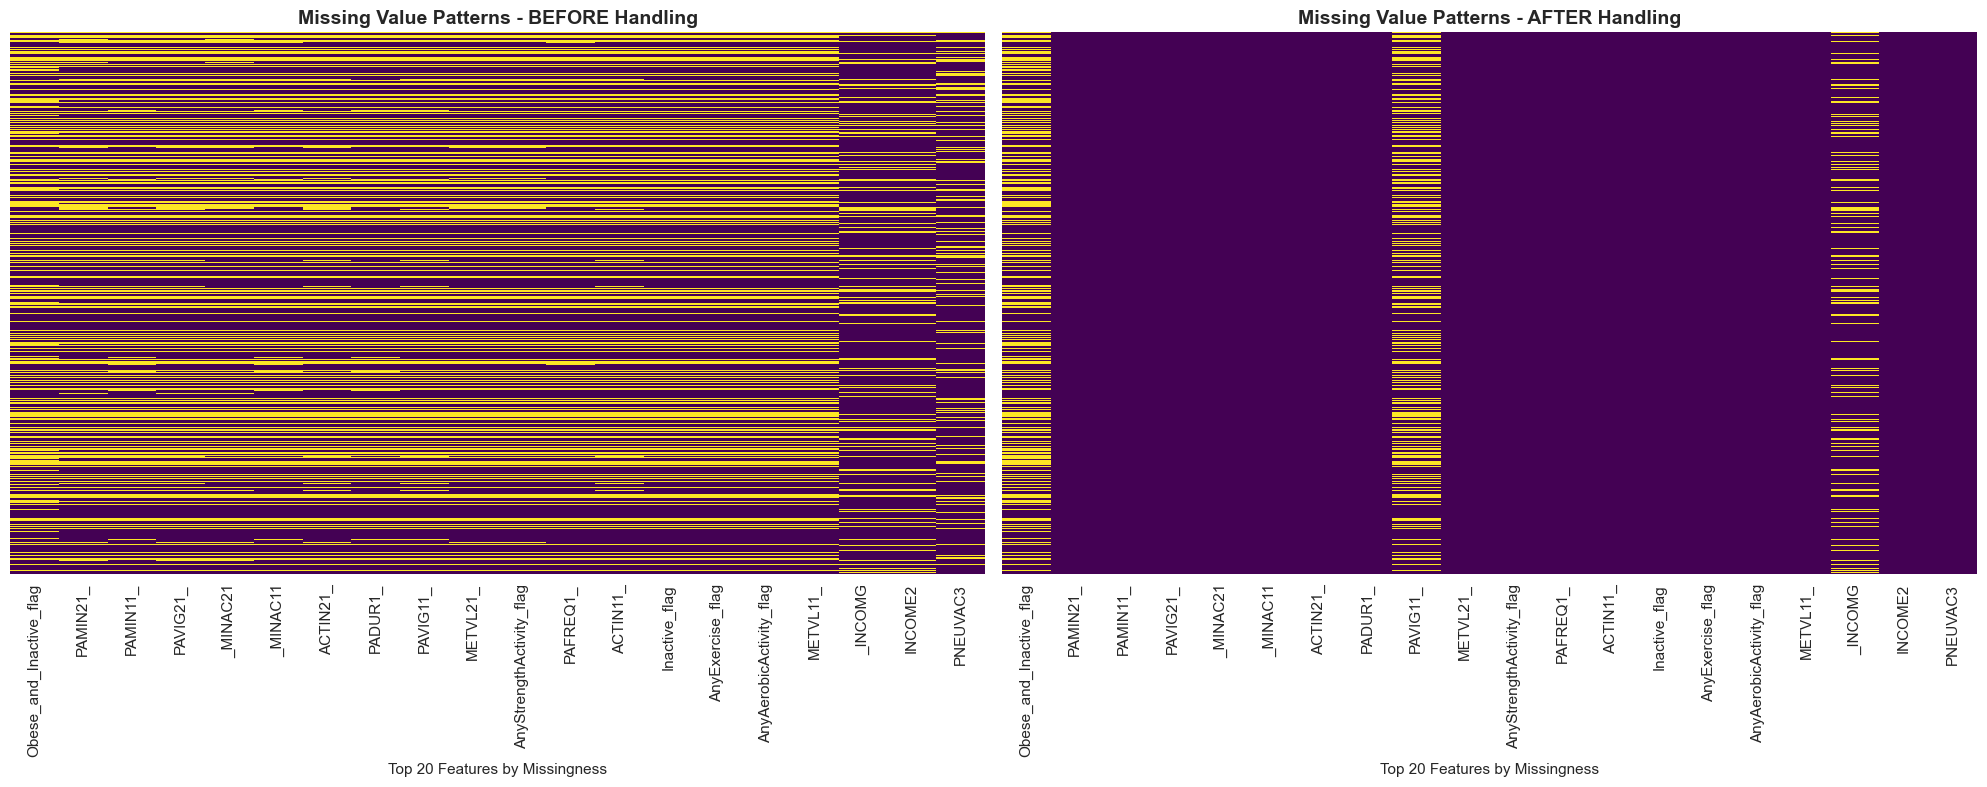

In [44]:
def plot_missing_comparison(df_before, df_after, title="Missing Value Patterns"):
    """Compare missing patterns before/after handling"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Calculate missing percentages
    missing_before = df_before.isna().mean() * 100
    missing_after = df_after.isna().mean() * 100
    
    # Plot top 20 variables with highest missingness
    top_vars = missing_before.sort_values(ascending=False).index[:20]
    
    # Before handling
    sns.heatmap(
        df_before[top_vars].isna(),
        cbar=False, 
        cmap='viridis',
        yticklabels=False,
        ax=ax1
    )
    ax1.set_title(f'{title} - BEFORE Handling', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Top 20 Features by Missingness')
    
    # After handling
    sns.heatmap(
        df_after[top_vars].isna(),
        cbar=False,
        cmap='viridis',
        yticklabels=False,
        ax=ax2
    )
    ax2.set_title(f'{title} - AFTER Handling', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Top 20 Features by Missingness')
    
    plt.tight_layout()
    plt.show()
    
plot_missing_comparison(df_fe, df_final)

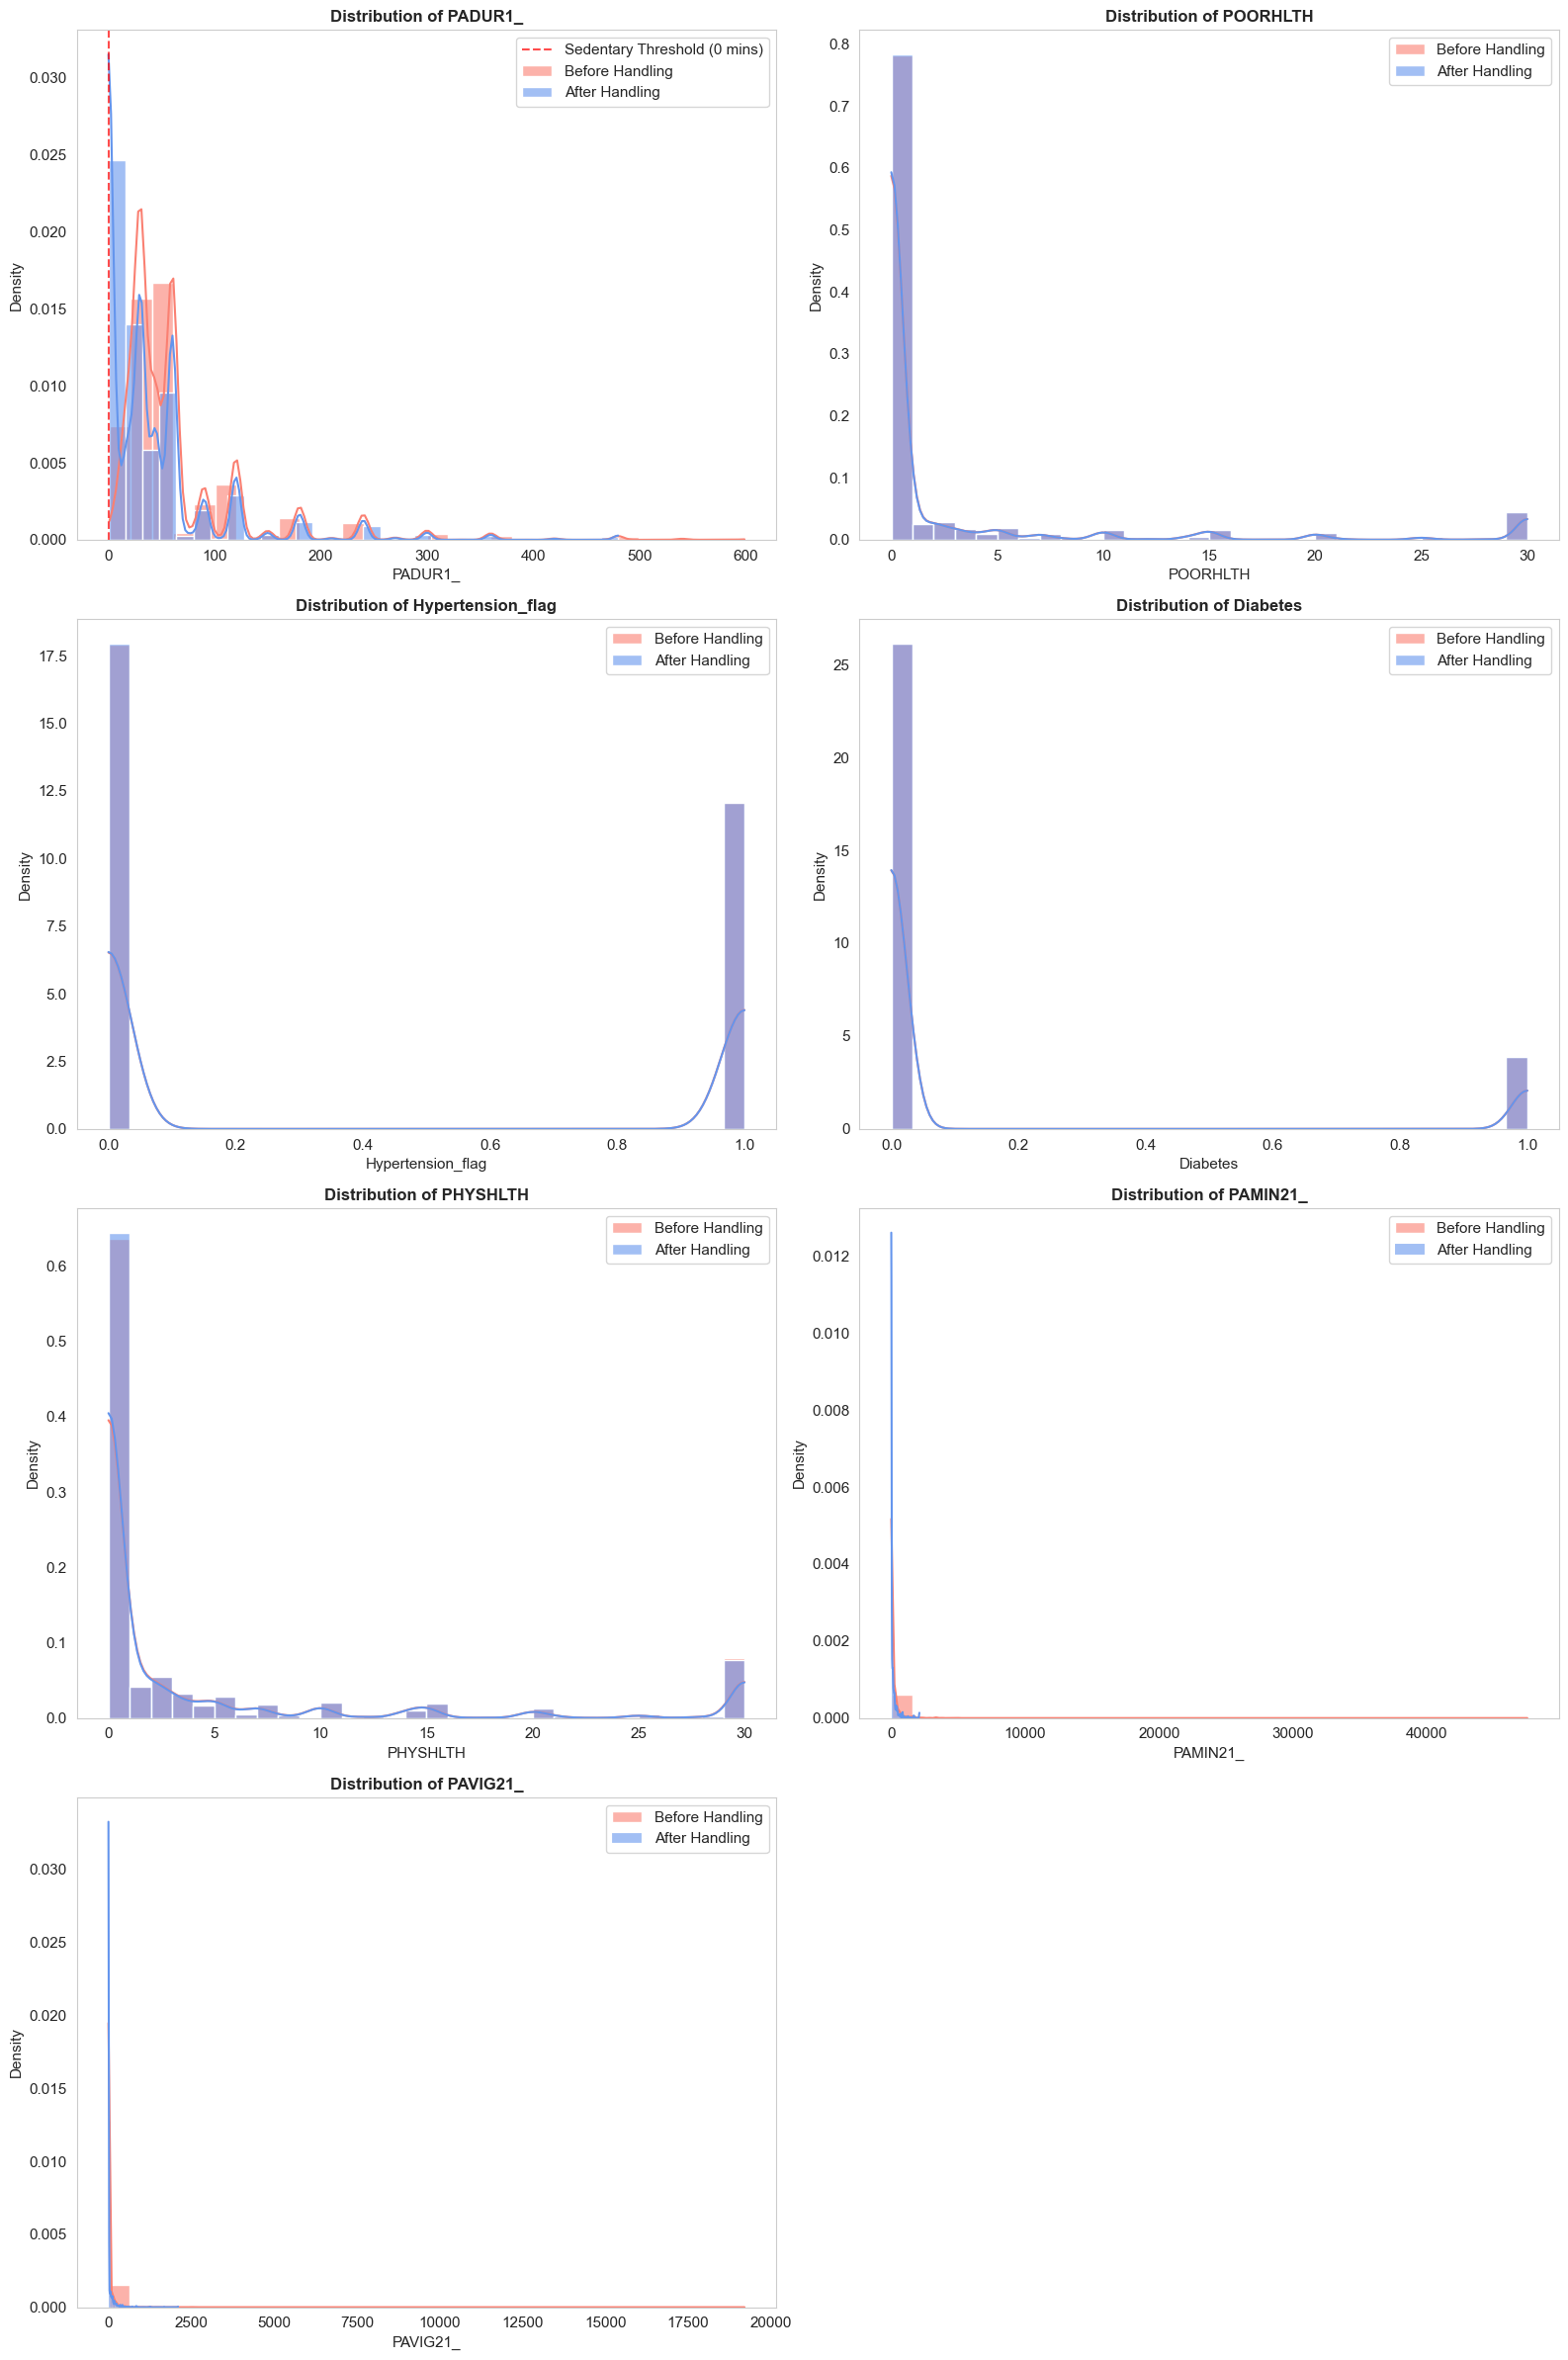

In [45]:
def plot_distribution_changes(df_before, df_after, critical_vars=None):
    """Show distribution changes for key clinical variables"""
    if critical_vars is None:
        critical_vars = [
            'PADUR1_', 'POORHLTH', 'Hypertension_flag', 'Diabetes',
            'INCOME2_Missing_flag', 'PNEUVAC3_Missing_flag',
            'PA_Detail_Input_Missing_flag', 'PHYSHLTH', "PAMIN21_", "PAVIG21_"
        ]
    
    available_vars = [v for v in critical_vars if v in df_before.columns]
    
    if not available_vars:
        print("No critical variables available for distribution comparison")
        return
    
    n_vars = len(available_vars)
    n_cols = 2
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
    axes = axes.flatten() if n_vars > 1 else [axes]
    
    for i, var in enumerate(available_vars):
        ax = axes[i]
        
        # Determine plot type based on variable type
        if pd.api.types.is_numeric_dtype(df_before[var]):
            # Numeric variable - histogram
            sns.histplot(
                data=df_before, x=var, bins=30, 
                stat='density', kde=True, color='salmon', alpha=0.6,
                label='Before Handling', ax=ax
            )
            sns.histplot(
                data=df_after, x=var, bins=30,
                stat='density', kde=True, color='cornflowerblue', alpha=0.6,
                label='After Handling', ax=ax
            )
            ax.set_title(f'Distribution of {var}', fontsize=12, fontweight='bold')
            ax.set_xlabel(var)
            ax.set_ylabel('Density')
            
            # Mark clinical thresholds
            if var == 'PADUR1_':
                ax.axvline(x=0, color='red', linestyle='--', alpha=0.7, 
                          label='Sedentary Threshold (0 mins)')
            elif var == 'AGE':
                ax.axvline(x=65, color='red', linestyle='--', alpha=0.7,
                          label='Elderly Threshold (65)')
        
        else:
            # Categorical variable - bar plot
            before_counts = df_before[var].value_counts(normalize=True) * 100
            after_counts = df_after[var].value_counts(normalize=True) * 100
            
            # Align categories
            all_categories = sorted(set(before_counts.index) | set(after_counts.index))
            before_aligned = [before_counts.get(cat, 0) for cat in all_categories]
            after_aligned = [after_counts.get(cat, 0) for cat in all_categories]
            
            x = np.arange(len(all_categories))
            width = 0.35
            
            ax.bar(x - width/2, before_aligned, width, color='salmon', alpha=0.8, 
                  label='Before Handling')
            ax.bar(x + width/2, after_aligned, width, color='cornflowerblue', alpha=0.8,
                  label='After Handling')
            
            ax.set_title(f'Distribution of {var}', fontsize=12, fontweight='bold')
            ax.set_xlabel(var)
            ax.set_ylabel('Percentage (%)')
            ax.set_xticks(x)
            ax.set_xticklabels(all_categories, rotation=45, ha='right')
        
        ax.legend()
    
    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
plot_distribution_changes(df_fe, df_final)

In [46]:
# Visualizing changes after outlier handling to data

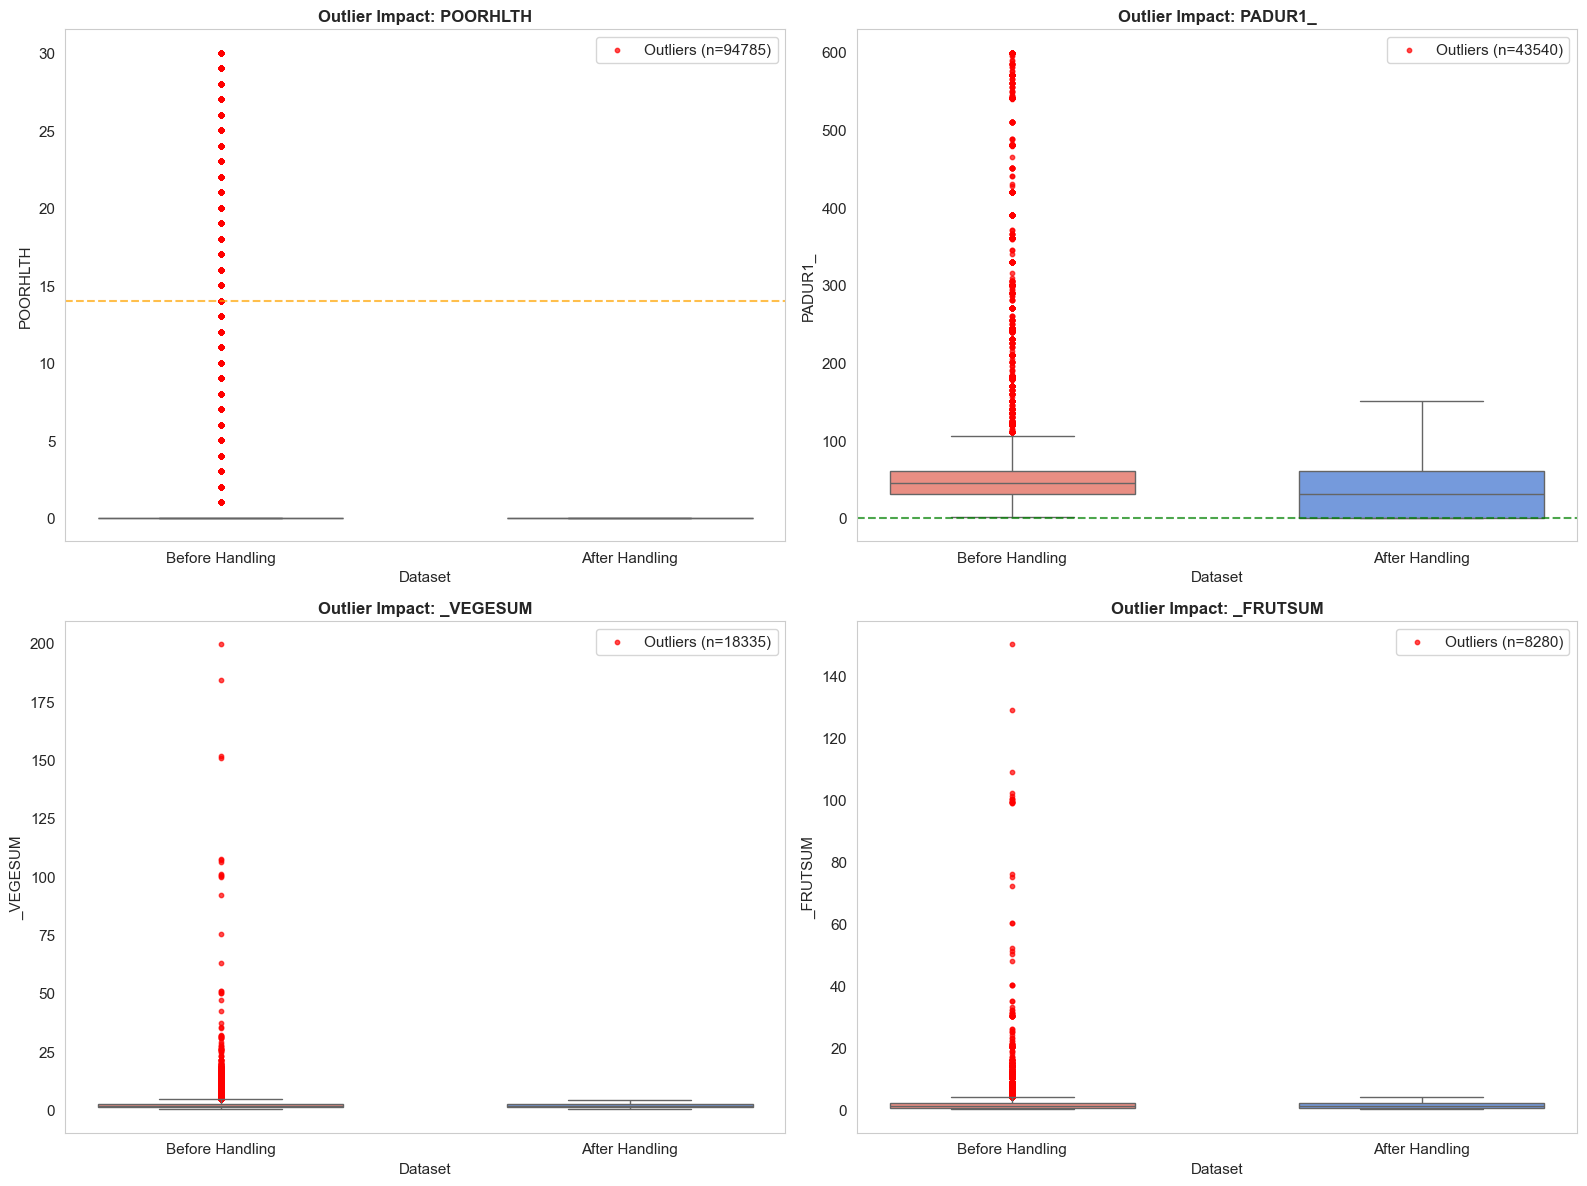

In [ ]:
def plot_outlier_impact(df_before, df_after, numeric_vars=None):
    """Visualize outlier handling impact with box plots"""
    if numeric_vars is None:
        # Auto-detect numeric variables
        numeric_vars = df_before.select_dtypes(include=['int64', 'float64']).columns.tolist()
        # Focus on key clinical variables
        key_numeric = ['POORHLTH', 'PADUR1_', 'AGE', '_VEGESUM', '_FRUTSUM']
        numeric_vars = [v for v in key_numeric if v in numeric_vars]
    
    if not numeric_vars:
        print("No numeric variables available for outlier analysis")
        return
    
    n_vars = len(numeric_vars)
    n_cols = 2
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
    axes = axes.flatten() if n_vars > 1 else [axes]
    
    for i, var in enumerate(numeric_vars):
        ax = axes[i]
        
        # Create comparison data
        comparison_df = pd.DataFrame({
            'Value': pd.concat([df_before[var], df_after[var]]),
            'Dataset': ['Before Handling'] * len(df_before) + ['After Handling'] * len(df_after)
        }).dropna(subset=['Value'])
        
        # Box plot with individual points for outliers
        sns.boxplot(
            data=comparison_df, x='Dataset', y='Value', 
            palette=['salmon', 'cornflowerblue'], 
            width=0.6, showfliers=False, ax=ax
        )
        
        # Add individual points for outliers (before handling only)
        before_outliers = df_before[var][df_before[var].notna()]
        if len(before_outliers) > 0:
            # Calculate IQR for outlier detection
            Q1 = before_outliers.quantile(0.25)
            Q3 = before_outliers.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Identify outliers
            outliers = before_outliers[(before_outliers < lower_bound) | (before_outliers > upper_bound)]
            
            if len(outliers) > 0:
                ax.scatter(
                    [0] * len(outliers), outliers, 
                    color='red', alpha=0.7, s=10, 
                    label=f'Outliers (n={len(outliers)})'
                )
        
        ax.set_title(f'Outlier Impact: {var}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Dataset')
        ax.set_ylabel(var)
        ax.legend()
        
        # Add clinical context annotations
        if var == 'PADUR1_':
            ax.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Sedentary (0 mins)')
        elif var == 'POORHLTH':
            ax.axhline(y=14, color='orange', linestyle='--', alpha=0.7, label='High Impact (14+ days)')
    
    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    
    # Save to reports/figures with correct naming format
    OUTPUT_DIR = Path('..') / 'reports' / 'figures'
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / '04_01_outlier_impact.png', dpi=300, bbox_inches='tight')
    
    plt.show()
plot_outlier_impact(df_fe, df_final)

---
# 9. CREATE FE DATASET
---


In [48]:
# Import and run FE dataset creatio
from src.create_fe_dataset import create_fe_dataset

# Create feature-engineered dataset
df_fe_full = create_fe_dataset(
    input_file="clean_2015.csv",
    output_file="fe_2015.csv"
)

print("\n✅ FE dataset created successfully!")


CREATING FEATURE-ENGINEERED (FE) DATASET

1. Loading clean dataset: clean_2015.csv
   Shape: (437514, 86)
   Columns: 86

2. Applying feature engineering transformations...
   (These are deterministic transformations with no data leakage)
   - Age features... 
AGE FEATURES
✓ (+4 columns)
   - Sex features...    Shape: (437514, 86)
   Columns: 86

2. Applying feature engineering transformations...
   (These are deterministic transformations with no data leakage)
   - Age features... 
AGE FEATURES
✓ (+4 columns)
   - Sex features... 
SEX FEATURES
✓ (+1 columns)
   - Race features... 
RACE FEATURES

SEX FEATURES
✓ (+1 columns)
   - Race features... 
RACE FEATURES
✓ (+3 columns)
   - Employment features... 
EMPLOYMENT FEATURES
✓ (+3 columns)
   - Employment features... 
EMPLOYMENT FEATURES
✓ (+1 columns)
   - BMI features... 
BMI FEATURES
✓ (+1 columns)
   - BMI features... 
BMI FEATURES
✓ (+3 columns)
   - Hypertension features... ✓ (+3 columns)
   - Hypertension features... 
HYPERTENSION